In [227]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Create the environment

In [228]:
class GridWorld:
    def __init__(self, width, height, bomb_positions, gold_positions, wall_positions, initial_position):
        self.width = width
        self.height = height
        self.bomb_positions = bomb_positions
        self.gold_positions = gold_positions
        self.wall_positions = wall_positions
        self.initial_position = initial_position

    def is_valid(self, x, y):
        if (x, y) not in self.wall_positions and 0 <= x < self.width and 0 <= y < self.height:
            return True
        return False

    def step(self, position, action):
        x, y = position
        if action == 0:  # Up
            y -= 1
        elif action == 1:  # Down
            y += 1
        elif action == 2:  # Left
            x -= 1
        elif action == 3:  # Right
            x += 1

        if not self.is_valid(x, y):
            x, y = position

        reward = -1
        if position == (x, y):  
            reward = -5
        done = False
        if (x, y) in self.bomb_positions:
            reward = -100
            done = True
        elif (x, y) in self.gold_positions:
            reward = 100
            done = True

        return (x, y), reward, done

    def print_grid(self):
        for y in range(self.height):
            row = []
            for x in range(self.width):
                if (x, y) == self.initial_position:
                    row.append('A')
                elif (x, y) in self.bomb_positions:
                    row.append('B')
                elif (x, y) in self.gold_positions:
                    row.append('G')
                elif (x, y) in self.wall_positions:
                    row.append('|')
                else:
                    row.append('.')
            print(''.join(row))
        print()

# Q-learning agent

In [229]:
class QLearningAgent:
    def __init__(self, actions=[0, 1, 2, 3], learning_rate=0.3, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.9995):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.actions = actions
        self.q_table = {}

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q(state, action) for action in self.actions]
            return self.actions[np.argmax(q_values)]

    def learn(self, old_state, reward, new_state, action):
        old_q = self.get_q(old_state, action)
        new_q = reward + self.discount_factor * np.max([self.get_q(new_state, a) for a in self.actions])
        self.q_table[(old_state, action)] = old_q + self.learning_rate * (new_q - old_q)
        self.exploration_rate *= self.exploration_decay

# Function for training and testing the agent

In [230]:

def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    reward_per_episode = [] 
    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        state = environment.initial_position
        while step < max_steps_per_episode and not game_over:
            action = agent.choose_action(state)
            new_state, reward, done = environment.step(state, action)

            if learn:
                agent.learn(state, reward, new_state, action)

            cumulative_reward += reward
            step += 1
            state = new_state

            if done:
                environment.__init__(environment.width, environment.height, environment.bomb_positions, environment.gold_positions, environment.wall_positions, environment.initial_position)
                game_over = True
        reward_per_episode.append(cumulative_reward)
    return reward_per_episode

# Set up the environment

In [231]:
map_variants = [
    {
        "name": "Map 1: Minefield",
        "width": 20,
        "height": 20,
        "bomb_positions": [(i, j) for i in range(1, 19) for j in range(1, 19) if (i + j) % 2 == 0],
        "gold_positions": [(19, 19)],
        "wall_positions": [],
        "initial_position": (0, 0)
    },
    {
        "name": "Map 2: Walls and Minefield",
        "width": 20,
        "height": 20,
        "bomb_positions": [(i, j) for i in range(1, 19) for j in range(1, 19) if (i + j) % 2 == 1],
        "gold_positions": [(19, 19)],
        "wall_positions": [(i, j) for i in range(1, 19) for j in range(1, 19) if (i + j) % 4 == 0],
        "initial_position": (0, 0)
    },
    {
        "name": "Map 3: One Bomb and One Wall",
        "width": 15,
        "height": 15,
        "bomb_positions": [(7, 7)],
        "gold_positions": [(14, 14)],
        "wall_positions": [(8, 8)],
        "initial_position": (0, 0)
    },
    {
        "name": "Map 4: Bombs in the walls",
        "width": 20,
        "height": 20,
        "bomb_positions": [(i, j) for i in range(1, 19, 6) for j in range(1, 19, 6)],
        "gold_positions": [(19, 19)],
        "wall_positions": [(i, j) for i in range(1, 19, 6) for j in range(2, 18, 6)] + [(i, j) for i in range(2, 18, 6) for j in range(1, 19, 6)],
        "initial_position": (0, 0)
    },
    {
        "name": "Map 5: Double walls and bombs",
        "width": 20,
        "height": 20,
        "bomb_positions": [(i, j) for i in range(0, 20, 4) for j in range(0, 20, 4)],
        "gold_positions": [(19, 19)],
        "wall_positions": [(i, j) for i in range(1, 20, 4) for j in range(0, 19, 4)] + [(i, j) for i in range(2, 20, 4) for j in range(0, 18, 4)],
        "initial_position": (0, 0)
    },
    {
        "name": "Map Variant 6: X",
        "width": 20,
        "height": 20,
        "bomb_positions": [],
        "gold_positions": [(11, 10)],
        "wall_positions": [(i, i) for i in range(0, 19)] + [(i, 19 - i) for i in range(0, 19)],
        "initial_position": (2, 1)
    },    
    {
        "name": "Map Variant 7: Straight Wall Labyrinth",
        "width": 20,
        "height": 20,
        "wall_positions": [],
        "gold_positions": [(19, 19)],
        "bomb_positions": [(i, j) for i in range(0, 20) for j in range(0, 20, 4) if i != j and i != j+1 and j != i+1],
        "initial_position": (0, 0)
    },
    {
        "name": "Map Variant 8: Straight Bomb Row Maze",
        "width": 20,
        "height": 20,
        "wall_positions": [(i, j) for i in range(0, 20, 2) for j in range(1, 20) if i != j] + [(i, j) for i in range(0, 20) for j in range(0, 20, 2) if i != j and i != j+1 and j != i+1],
        "gold_positions": [(19, 19)],
        "bomb_positions": [],
        "initial_position": (0, 0)
    },
]


# Q-learning parameters

Map 1: Minefield
A...................
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
.B.B.B.B.B.B.B.B.B..
..B.B.B.B.B.B.B.B.B.
...................G



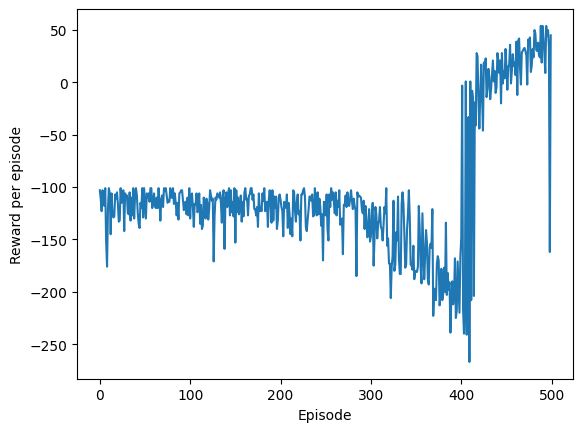

Map 2: Walls and Minefield
A...................
..B|B.B|B.B|B.B|B.B.
.B|B.B|B.B|B.B|B.B|.
.|B.B|B.B|B.B|B.B|B.
.B.B|B.B|B.B|B.B|B..
..B|B.B|B.B|B.B|B.B.
.B|B.B|B.B|B.B|B.B|.
.|B.B|B.B|B.B|B.B|B.
.B.B|B.B|B.B|B.B|B..
..B|B.B|B.B|B.B|B.B.
.B|B.B|B.B|B.B|B.B|.
.|B.B|B.B|B.B|B.B|B.
.B.B|B.B|B.B|B.B|B..
..B|B.B|B.B|B.B|B.B.
.B|B.B|B.B|B.B|B.B|.
.|B.B|B.B|B.B|B.B|B.
.B.B|B.B|B.B|B.B|B..
..B|B.B|B.B|B.B|B.B.
.B|B.B|B.B|B.B|B.B|.
...................G



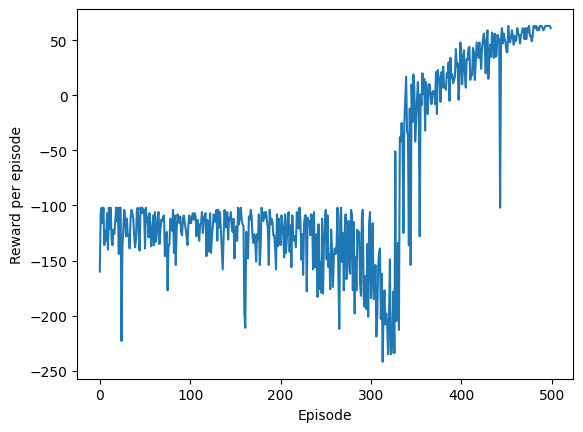

Map 3: One Bomb and One Wall
A..............
...............
...............
...............
...............
...............
...............
.......B.......
........|......
...............
...............
...............
...............
...............
..............G



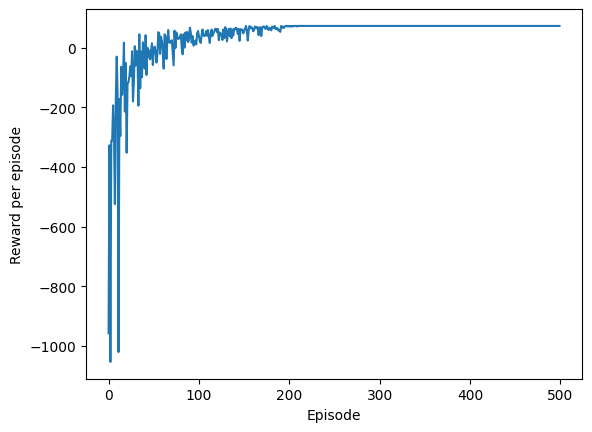

Map 4: Bombs in the walls
A...................
.B|....B|....B|.....
.|.....|.....|......
....................
....................
....................
....................
.B|....B|....B|.....
.|.....|.....|......
....................
....................
....................
....................
.B|....B|....B|.....
.|.....|.....|......
....................
....................
....................
....................
...................G



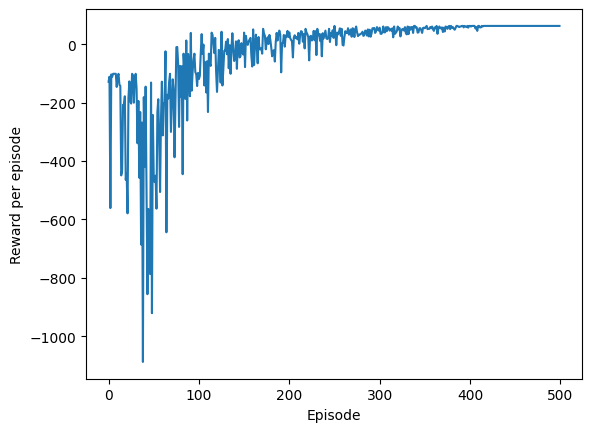

Map 5: Double walls and bombs
A||.B||.B||.B||.B||.
....................
....................
....................
B||.B||.B||.B||.B||.
....................
....................
....................
B||.B||.B||.B||.B||.
....................
....................
....................
B||.B||.B||.B||.B||.
....................
....................
....................
B||.B||.B||.B||.B||.
....................
....................
...................G



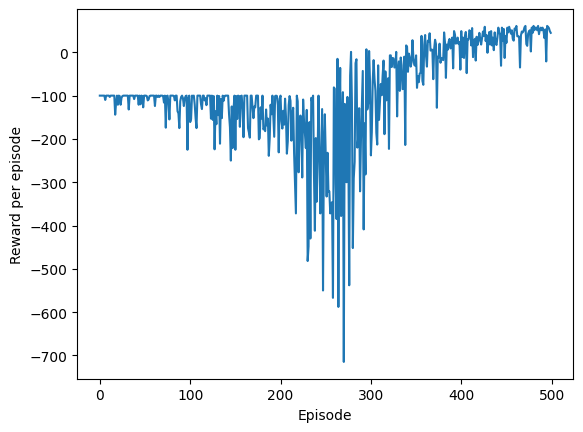

Map Variant 6: X
|...................
.|A...............|.
..|..............|..
...|............|...
....|..........|....
.....|........|.....
......|......|......
.......|....|.......
........|..|........
.........||.........
.........||G........
........|..|........
.......|....|.......
......|......|......
.....|........|.....
....|..........|....
...|............|...
..|..............|..
.|................|.
|...................



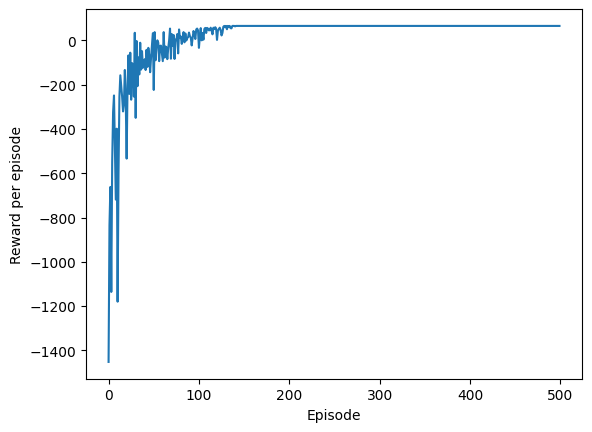

Map Variant 7: Straight Wall Labyrinth
A.BBBBBBBBBBBBBBBBBB
....................
....................
....................
BBB...BBBBBBBBBBBBBB
....................
....................
....................
BBBBBBB...BBBBBBBBBB
....................
....................
....................
BBBBBBBBBBB...BBBBBB
....................
....................
....................
BBBBBBBBBBBBBBB...BB
....................
....................
...................G



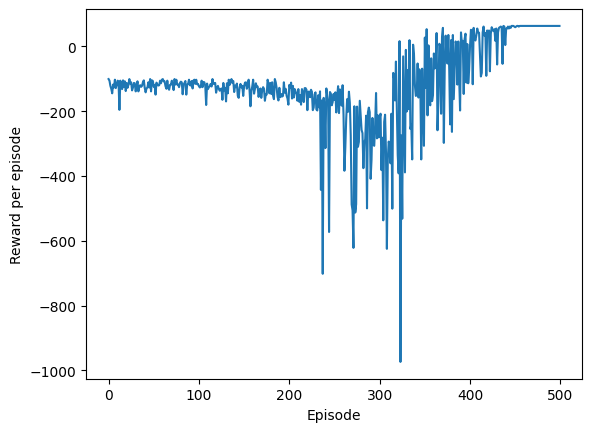

Map Variant 8: Straight Bomb Row Maze
A.||||||||||||||||||
|.|.|.|.|.|.|.|.|.|.
|...||||||||||||||||
|.|.|.|.|.|.|.|.|.|.
|||...||||||||||||||
|.|.|.|.|.|.|.|.|.|.
|||||...||||||||||||
|.|.|.|.|.|.|.|.|.|.
|||||||...||||||||||
|.|.|.|.|.|.|.|.|.|.
|||||||||...||||||||
|.|.|.|.|.|.|.|.|.|.
|||||||||||...||||||
|.|.|.|.|.|.|.|.|.|.
|||||||||||||...||||
|.|.|.|.|.|.|.|.|.|.
|||||||||||||||...||
|.|.|.|.|.|.|.|.|.|.
|||||||||||||||||...
|.|.|.|.|.|.|.|.|.|G



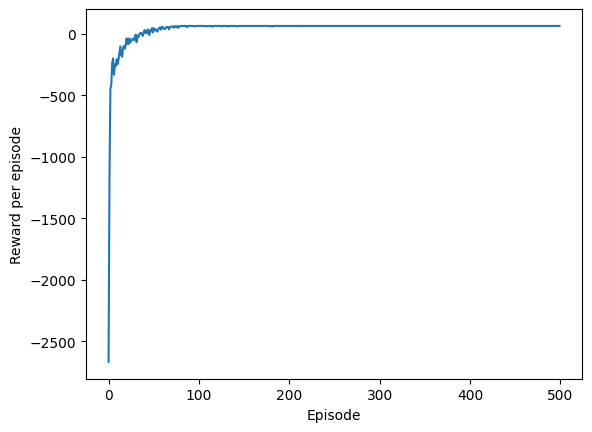

In [232]:
reward_per_episode_all_maps = []
for variant in map_variants:
    env = GridWorld(
        variant["width"],
        variant["height"],
        variant["bomb_positions"],
        variant["gold_positions"],
        variant["wall_positions"],
        variant["initial_position"]
    )
    print(variant["name"])
    env.print_grid()
    q_learning_agent = QLearningAgent()
    reward_per_episode = play(env, q_learning_agent, trials=500, learn=True)

    plt.plot(reward_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Reward per episode")
    plt.show()

    reward_per_episode_all_maps.append(reward_per_episode)



# Simple learning curve

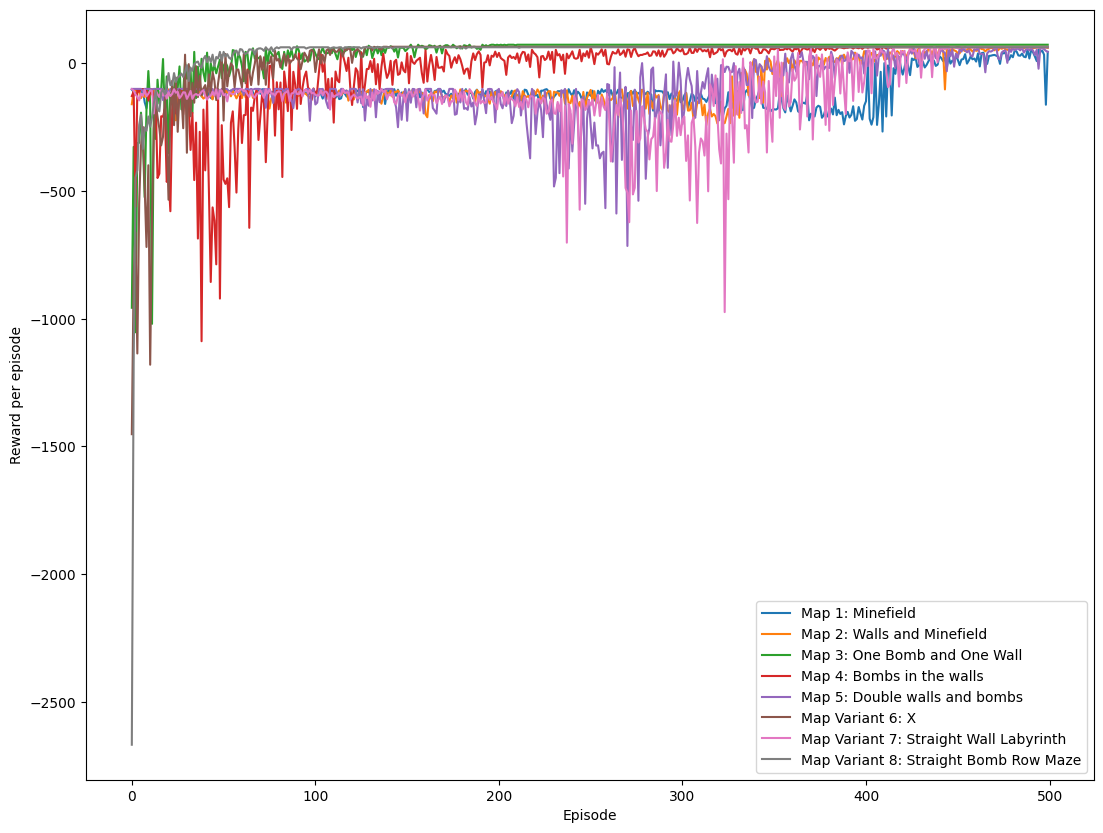

In [233]:
plt.figure(figsize=(13, 10))  

for i, reward_per_episode in enumerate(reward_per_episode_all_maps):
    plt.plot(reward_per_episode, label=map_variants[i]["name"])

plt.xlabel("Episode")
plt.ylabel("Reward per episode")
plt.legend(loc="lower right")  
plt.show()
